In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [5]:

# Path: watershed_class.ipynb

class image_processor:
    def __init__(self, bgr_image):
        self.img = bgr_image
        self.org_img = self.img.copy()
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.cropped_objects = []
        self.processing_steps_images = []
        self.processing_steps_labels = ["Original Image", "Mask Image", "Distance Transform", "Foreground Image"]
        self.all_cnts = []  # Store detected contours
        self.cropped_objects_info = []  # Store cropped objects info
        
    def create_mask(self):
        # Apply threshod and fill holes
        lower = np.array([70, 70, 70])
        upper = np.array([255, 255, 255])
        mask = cv2.bitwise_not(cv2.inRange(self.img, lower, upper))

        # Filling holes
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            cv2.drawContours(mask, [contour], 0, 255, -1)  # 255 is color, -1 means fill the contour  
        return mask
    
    def resize_with_padding(self, img, target_size=(128, 128), fill_value=0):
        """
        Resize the input image to the target size, maintaining the original aspect ratio by padding.
        """
        h, w = img.shape[:2]
        ratio = min(target_size[0] / h, target_size[1] / w)
        new_size = (int(w * ratio), int(h * ratio))
        resized_img = cv2.resize(img, new_size)

        delta_w = target_size[1] - new_size[0]
        delta_h = target_size[0] - new_size[1]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=fill_value)
        return padded_img
    
    def display_results(self):
        for i, cropped in enumerate(self.cropped_objects):
            plt.subplot(1, len(self.cropped_objects), i + 1)
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            plt.title(f"Cropped Object {i + 1}")
            plt.axis('off')
        plt.show()
    
    def display_masks(self):
        #display first image in original coours and reamining in gray
        fig, ax = plt.subplots(1, len(self.processing_steps_images), figsize=(20, 20))
        for i, img in enumerate(self.processing_steps_images):
            if i == 0:
                ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax[i].imshow(img, cmap='gray')
            ax[i].set_title(self.processing_steps_labels[i])
            ax[i].axis('off')

    def apply_watershed(self):
        self.processing_steps_images.append(self.img)
        thresh = self.create_mask()
        self.processing_steps_images.append(thresh)

        sure_bg = cv2.dilate(thresh, np.ones((5, 5), np.uint8), iterations=1)

        dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
        self.processing_steps_images.append(dist_transform)
        self.processing_steps_images.append(sure_fg)


        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        cv2.watershed(self.img, markers)
        self.img[markers == -1] = [0, 0, 255]
        

        for label in np.unique(markers):
            # If the label is 0 or 1, it's background or unknown region. So, we skip.
            if label <= 1: 
                continue
            mask = np.zeros(self.gray.shape, dtype="uint8")
            mask[markers == label] = 255
            cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for c in cnts:
                x, y, w, h = cv2.boundingRect(c)
                cropped = self.org_img[y:y+h, x:x+w]
                cropped_resized = self.resize_with_padding(cropped)
                center_x = x + w // 2
                center_y = y + h // 2

                cropped_info = {
                    'cropped_image': cropped_resized,
                    'center_coordinates': (center_x, center_y),
                    'bounding_box': (x, y, w, h)  # Store the bounding box as well
                }
                self.cropped_objects_info.append(cropped_info)
                self.cropped_objects.append(cropped_resized)  
            self.all_cnts.append(cnts)
    
    def draw_rectangles(self):
        # Ensure self.org_img is a copy of the original image if you don't want to overwrite it.
        display_img = self.org_img.copy()

        # Iterate through all detected contours and draw rectangles.
        for cnts in self.all_cnts:
            for c in cnts:
                # Compute the bounding box for the contour.
                x, y, w, h = cv2.boundingRect(c)
                # Draw the rectangle on the image.
                cv2.rectangle(display_img, (x, y), (x + w, y + h), (0, 255, 0), 5)
                # Calculate the center of the rectangle
                center_x = int(x + w / 2)
                center_y = int(y + h / 2)
                
                # Draw a small circle at the center
                cv2.circle(display_img, (center_x, center_y), radius=20, color=(0, 255, 0), thickness=-1)
                # Annotate the center with the coordinates
                cv2.putText(display_img, f"({center_x}, {center_y})", (center_x + 5, center_y + 5), 
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 12)

        # Convert the image from BGR to RGB, as OpenCV uses BGR by default and matplotlib uses RGB.
        display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)

        # Use matplotlib to display the image.
        plt.imshow(display_img)
        plt.axis('off')  # Turn off axis numbers and ticks.
        plt.show()  # Display the image with the drawn rectangles and annotated centers.

In [6]:
t9 = cv2.imread('T11.jpg')
img = image_processor(t9)
img.apply_watershed()

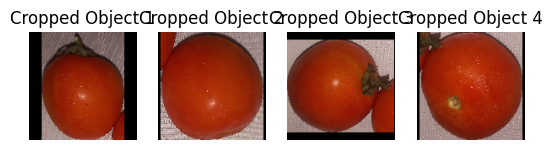

In [7]:
img.display_results()